### Import Necessary Module and Set Path 

In [1]:
import sqlite3 as lite
import os
import sys
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import collections
sys.path.insert(0, '../../scripts/')
jupyter_directory = os.getcwd()
from decimal import Decimal
from pyne.material import Material

/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.data is not yet QA compliant.
  return f(*args, **kwds)
/home/teddy/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: QAWarning: pyne.material is not yet QA compliant.
  return f(*args, **kwds)


# analysis
This jupyter notebook obtains important metrics and figures from the U.S. transition from LWR fleet to MSR fleet. This notebook calculates the following metrics:
* power capacity installed
* LWR UNF generated
* LWR UNF inventory
* Fuel salt mass vs time
* Total TRU extracted from LWR UNF
* Total LWR UNF reprocessed
* Average monthly reprocessing / fabrication demand
* Total raffinate stockpile
* Total waste inventory
* Total natural uranium usage


In [2]:
import analysis as an
! rm power_plot.png

In [3]:
# get sqlite cursor and simulation time data
cur = an.get_cursor('cyclus.sqlite')
init_year, init_month, duration, timestep = an.get_timesteps(cur)

In [4]:
power_dict = an.get_power_dict(cur)
pow = {'legacy lwrs': power_dict['us_government'], 'lwr': power_dict['lwr_inst'], 'msr': power_dict['rebus_inst']}
legacy_only = {'legacy lwrs': power_dict['us_government'][:810]}
an.stacked_bar_chart(pow, timestep, 'Year', 'Net Capacity [GWe]', 'Installed nuclear capacity in the U.S.',
                     'power_plot', init_year)
an.stacked_bar_chart(legacy_only, timestep[:810], 'Year', 'Net Capacity [GWe]', 'Installed nuclear capacity in the U.S.',
                     'legacy_only', init_year)


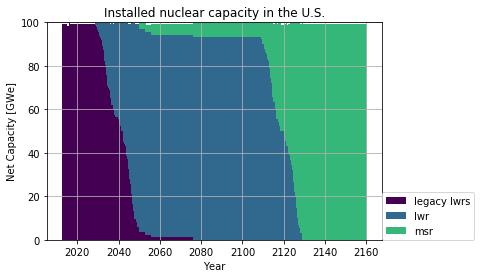

In [5]:
Image('power_plot.png')

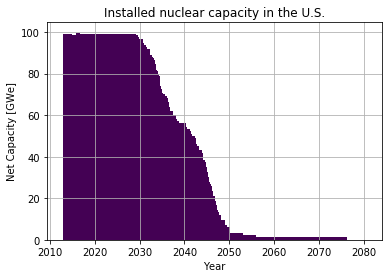

In [6]:
Image('legacy_only.png')

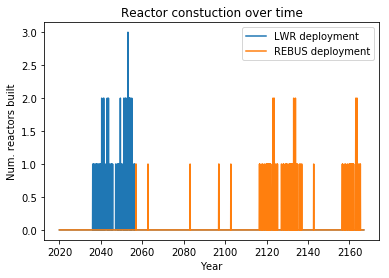

Total deployed:
lwr: 84 ( 92400 )
rebus: 95 ( 154660.0 )


In [8]:
# total lwrs and msrs deployed

lwrs = cur.execute('SELECT entertime, lifetime/lifetime from agententry where prototype = "lwr"').fetchall()
rebus = cur.execute('SELECT entertime, lifetime/lifetime from agententry where prototype = "rebus"').fetchall()
lwrs = an.get_timeseries(lwrs, duration, False)
rebus = an.get_timeseries(rebus, duration, False)
years = 2020 + np.arange(0, duration)/12
plt.plot(years, lwrs, label='LWR deployment')
plt.plot(years, rebus, label='REBUS deployment')
plt.xlabel('Year')
plt.ylabel('Num. reactors built')
plt.legend()
plt.title('Reactor constuction over time')
plt.savefig('us_dep.png', format='png')
plt.show()

print('Total deployed:')
print('lwr:', sum(lwrs), '(', sum(lwrs) * 1100, ')')
print('rebus:', sum(rebus), '(' , sum(rebus) * 3700 * 0.44, ')')

In [9]:
from pyne import nucname
def get_tru_massfrac(commodity):
    commodity_qualid = cur.execute('SELECT qualid FROM transactions INNER JOIN resources ON '
                                   'resources.resourceid = transactions.resourceid WHERE '
                                   'commodity = "%s"' %commodity).fetchone()[0]
    massfracs = cur.execute('SELECT nucid, massfrac FROM compositions where qualid = %s' %str(commodity_qualid)).fetchall()
    comp_dict = {}
    for row in massfracs:
        if int(row['nucid']) < 930000000 or int(row['nucid']) > 970000000:
            continue
        key = nucname.name(row['nucid'])
        comp_dict[key] = row['massfrac']
    return comp_dict

In [10]:
def get_u_massfrac(commodity):
    commodity_qualid = cur.execute('SELECT qualid FROM transactions INNER JOIN resources ON '
                                   'resources.resourceid = transactions.resourceid WHERE '
                                   'commodity = "%s"' %commodity).fetchone()[0]
    massfracs = cur.execute('SELECT nucid, massfrac FROM compositions where qualid = %s' %str(commodity_qualid)).fetchall()
    ufrac = 0
    for row in massfracs:
        if int(row['nucid']) < 920000000 or int(row['nucid']) > 930000000:
            continue
        ufrac += row['massfrac']
    return ufrac

In [11]:
def get_massfrac(commodity):
    commodity_qualid = cur.execute('SELECT qualid FROM transactions INNER JOIN resources ON '
                                   'resources.resourceid = transactions.resourceid WHERE '
                                   'commodity = "%s"' %commodity).fetchone()[0]
    massfracs = cur.execute('SELECT nucid, massfrac FROM compositions where qualid = %s' %str(commodity_qualid)).fetchall()
    comp_dict = {}
    for row in massfracs:
        key = nucname.name(row['nucid'])
        comp_dict[key] = row['massfrac']
    return comp_dict

In [12]:
import math
def nansum_dict(dictionary):
    tot = 0
    for key, val in dictionary.items():
        if math.isnan(val):
            continue
        tot += val
    return tot

In [13]:
def tru_massfrac_to_vector(comp_dict):
    tot = sum(comp_dict.values())
    for key, val in comp_dict.items():
        comp_dict[key] = val / tot
    return comp_dict

In [14]:
# TRU composition in Spent and initial Fuels:
lwr_unf_tru_comp = get_tru_massfrac('uox_waste')
init_salt_tru_comp = get_tru_massfrac('init_fuel')
eol_salt_tru_comp = get_tru_massfrac('fuel_out')

In [15]:
# TRU Composition
string = 'Isotope & Beginning of Life & End of Life \\\ \n'
for key, val in eol_salt_tru_comp.items():
    if val < 1e-04:
        continue
    string += key + ' & '
    try:
        bol_comp = init_salt_tru_comp[key]
    except:
        bol_comp = 0
    string += '%.2E' % Decimal(str(bol_comp)) + ' & '
    string += '%.2E' % Decimal(str(val)) + '\\\ \n'

string += 'Total & ' + str(sum(init_salt_tru_comp.values())) + ' & ' + str(sum(eol_salt_tru_comp.values())) + ' \\\ \n'
print(string)

Isotope & Beginning of Life & End of Life \\ 
Np237 & 4.61E-03 & 6.00E-04\\ 
Pu238 & 1.84E-03 & 2.06E-03\\ 
Pu239 & 5.33E-02 & 5.22E-02\\ 
Pu240 & 1.95E-02 & 2.81E-02\\ 
Pu241 & 5.07E-03 & 3.28E-03\\ 
Pu242 & 4.77E-03 & 3.90E-03\\ 
Am241 & 5.51E-03 & 1.67E-03\\ 
Am243 & 9.31E-04 & 1.19E-03\\ 
Cm244 & 4.03E-04 & 1.00E-03\\ 
Cm245 & 3.76E-05 & 2.64E-04\\ 
Cm246 & 4.80E-06 & 1.19E-04\\ 
Total & 0.0959546936471764 & 0.09453205358076015 \\ 



In [16]:
# TRU Composition
string = 'Isotope & Beginning of Life & End of Life \\\ \n'
sum1 = 0
sum2 = 0
for key, val in eol_salt_tru_comp.items():
    if val < 1e-04:
        continue
    val = val / sum(eol_salt_tru_comp.values())
    string += key + ' & '
    try:
        bol_comp = init_salt_tru_comp[key] / sum(init_salt_tru_comp.values())
    except:
        bol_comp = 0
    string += '%.2E' % Decimal(str(bol_comp)) + ' & '
    string += '%.2E' % Decimal(str(val)) + '\\\ \n'

print(string)

Isotope & Beginning of Life & End of Life \\ 
Np237 & 4.80E-02 & 6.34E-03\\ 
Pu238 & 1.91E-02 & 2.18E-02\\ 
Pu239 & 5.55E-01 & 5.52E-01\\ 
Pu240 & 2.03E-01 & 2.98E-01\\ 
Pu241 & 5.28E-02 & 3.47E-02\\ 
Pu242 & 4.97E-02 & 4.13E-02\\ 
Am241 & 5.74E-02 & 1.77E-02\\ 
Am243 & 9.70E-03 & 1.26E-02\\ 
Cm244 & 4.20E-03 & 1.06E-02\\ 
Cm245 & 3.92E-04 & 2.79E-03\\ 
Cm246 & 5.00E-05 & 1.26E-03\\ 



In [17]:
lwr_unf_tru_vec = tru_massfrac_to_vector(lwr_unf_tru_comp)
init_salt_tru_vec = tru_massfrac_to_vector(init_salt_tru_comp)
eol_salt_tru_vec = tru_massfrac_to_vector(eol_salt_tru_comp)

print(lwr_unf_tru_vec)
print(init_salt_tru_vec)
print(eol_salt_tru_vec)

{'Np237': 0.047308915605860334, 'Pu238': 0.022637142727796017, 'Pu239': 0.47107005808831415, 'Pu240': 0.22567253354153197, 'Pu241': 0.1365217889336543, 'Pu242': 0.0670882692410373, 'Pu244': 2.2248857792867747e-06, 'Am241': 0.005003469136455384, 'Am242M': 6.627286296835368e-05, 'Am243': 0.015407239123318452, 'Cm242': 0.0020113278074529646, 'Cm243': 5.9876553819315204e-05, 'Cm244': 0.006649030381240261, 'Cm245': 0.0004443558963029291, 'Cm246': 5.665887136361708e-05, 'Cm247': 7.766089989535046e-07, 'Cm248': 5.973410615802392e-08, 'Cm250': 3.3245151906201306e-16}
{'Np237': 0.04802950142018718, 'Np238': 1.039337901575956e-11, 'Np239': 8.356128648187144e-09, 'Np240': 6.4344620179821036e-18, 'Pu238': 0.01914812530313312, 'Pu239': 0.5551709091095284, 'Pu240': 0.20329858554911281, 'Pu241': 0.052787326302600454, 'Pu242': 0.04974445133955743, 'Pu243': 2.4460157358746052e-17, 'Pu244': 4.45226838781886e-06, 'Pu246': 1.5942251519941559e-22, 'Am241': 0.05737196207829727, 'Am242': 7.434719410978571e-1

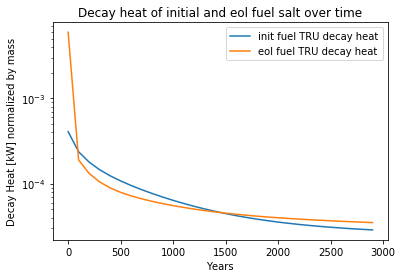

In [18]:
# compare decay heat / activity of init and final fuel
init_salt_mat = Material(init_salt_tru_vec) * 132659000 * 0.095598353
eol_salt_mat = Material(eol_salt_tru_vec) * 132659000 * 0.09552035
years = np.arange(0, 3000, 100)
init_decay_heat = np.zeros(len(years))
eol_decay_heat = np.zeros(len(years))
for indx, year in enumerate(years):
    sec = year * 365 * 24 * 3600
    decayed_init_mat = init_salt_mat.decay(sec)
    decayed_eol_mat = eol_salt_mat.decay(sec)
    init_decay_heat[indx] = nansum_dict(decayed_init_mat.decay_heat()) * 1e-3
    eol_decay_heat[indx] = nansum_dict(decayed_eol_mat.decay_heat()) * 1e-3

plt.semilogy(years, init_decay_heat, label='init fuel TRU decay heat')
plt.semilogy(years, eol_decay_heat, label='eol fuel TRU decay heat')
plt.xlabel('Years')
plt.ylabel('Decay Heat [kW] normalized by mass')
plt.title('Decay heat of initial and eol fuel salt over time')
plt.legend()
plt.show()

In [19]:
# TRU vector
string = 'Isotope & Beginning of Life & End of Life \\\ \n'
for key, val in eol_salt_tru_vec.items():
    if val < 1e-04:
        continue
    string += key + ' & '
    try:
        bol_comp = init_salt_tru_vec[key]
    except:
        bol_comp = 0
    string += '%.2E' % Decimal(str(bol_comp)) + ' & '
    string += '%.2E' % Decimal(str(val)) + '\\\ \n'


print(string)

Isotope & Beginning of Life & End of Life \\ 
Np237 & 4.80E-02 & 6.34E-03\\ 
Np239 & 8.36E-09 & 5.45E-04\\ 
Pu238 & 1.91E-02 & 2.18E-02\\ 
Pu239 & 5.55E-01 & 5.52E-01\\ 
Pu240 & 2.03E-01 & 2.98E-01\\ 
Pu241 & 5.28E-02 & 3.47E-02\\ 
Pu242 & 4.97E-02 & 4.13E-02\\ 
Am241 & 5.74E-02 & 1.77E-02\\ 
Am243 & 9.70E-03 & 1.26E-02\\ 
Cm242 & 1.79E-07 & 7.14E-04\\ 
Cm244 & 4.20E-03 & 1.06E-02\\ 
Cm245 & 3.92E-04 & 2.79E-03\\ 
Cm246 & 5.00E-05 & 1.26E-03\\ 
Cm247 & 6.86E-07 & 1.83E-04\\ 



In [20]:
lwr_unf_tru_comp = get_tru_massfrac('uox_waste')
init_salt_tru_comp = get_tru_massfrac('init_fuel')
eol_salt_tru_comp = get_tru_massfrac('fuel_out')

In [52]:
metric_dict = {}
agent_ids = an.get_agent_ids(cur, 'Reactor')
uox_waste = an.facility_commodity_flux(cur, agent_ids, ['uox_waste'], True, True)
metric_dict['US UNF UOX generated in 2013-2050'] = uox_waste['uox_waste'][439]
print('US UNF UOX generated in 2013-2050: %f' %uox_waste['uox_waste'][439])


US UNF UOX generated in 2013-2050: 78281.510000


In [53]:
agent_ids = an.get_agent_ids(cur, 'Source')
legacy_waste = an.facility_commodity_flux(cur, agent_ids, ['pre_2013_unf'], True, True)
metric_dict['US legacy LWR UNF in 2013'] = legacy_waste['pre_2013_unf'][-1]
print('US legacy UOX UNF in 2013: %f' %legacy_waste['pre_2013_unf'][-1])


US legacy UOX UNF in 2013: 68072.030000


In [54]:
agent_ids = an.get_prototype_id(cur, 'reprocessing')
us_rep = an.facility_commodity_flux(cur, agent_ids, ['cooled_uox', 'pre_2013_unf'], False, True)
print('US UNF reprocesed up until 2050: %f' %(us_rep['cooled_uox'][439] + us_rep['cooled_uox'][439]))


US UNF reprocesed up until 2050: 116457.180000


In [55]:
total_unf = uox_waste['uox_waste'][439] + metric_dict['US legacy LWR UNF in 2013']
metric_dict['Total US LWR UNF inventory in 2050'] =  total_unf
print('TOTAL UOX UNF inventory in US in 2050: %f' %total_unf)

TOTAL UOX UNF inventory in US in 2050: 146353.540000


In [66]:
total_unf = uox_waste['uox_waste'][-1] + metric_dict['US legacy LWR UNF in 2013']
metric_dict['Total US LWR UNF inventory generated'] =  total_unf
print('TOTAL UOX UNF inventory in US: %f' %total_unf)

TOTAL UOX UNF inventory in US: 265048.158000


In [67]:
print('TOTAL UNF created from 2013: %f' %(total_unf - metric_dict['US legacy LWR UNF in 2013']))

TOTAL UNF created from 2013: 196976.128000


Total init salt mass sent to MSRs: 19015.162585


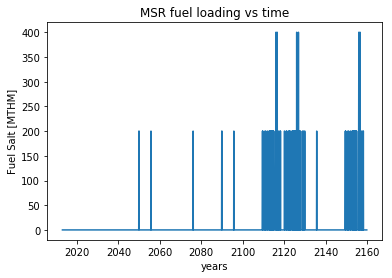

In [57]:
# Salt created
agent_ids = an.get_agent_ids(cur, 'Mixer')
init_salt = an.facility_commodity_flux(cur, agent_ids, ['init_fuel'], True, False)
metric_dict['Total fuel salt mass sent to MSRs'] = sum(init_salt['init_fuel'])
print('Total init salt mass sent to MSRs: %f' %sum(init_salt['init_fuel']))
years = 2013 + np.arange(0, duration)/12
plt.plot(years, init_salt['init_fuel'])
plt.title('MSR fuel loading vs time')
plt.xlabel('years')
plt.ylabel('Fuel Salt [MTHM]')
plt.savefig('msr_fuel', format='png')

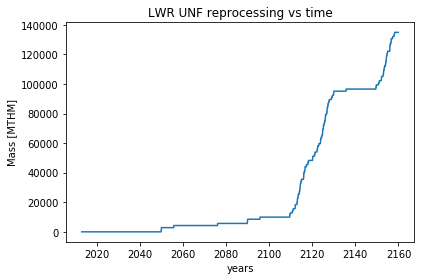

In [58]:
# lwr reprocessed and tru separated
init_salt = an.facility_commodity_flux(cur, agent_ids, ['init_fuel'], True, True)
init_salt_tru = np.array(init_salt['init_fuel']) * sum(init_salt_tru_comp.values())
lwr_unf_reproc = init_salt_tru / sum(lwr_unf_tru_comp.values())

plt.plot(years, lwr_unf_reproc)
plt.title('LWR UNF reprocessing vs time')
plt.xlabel('years')
plt.ylabel('Mass [MTHM]')
plt.tight_layout()
plt.savefig('lwr_unf_reproc', format='png')

Total TRU extracted: 1824.5941005008417 MTHM of TRU


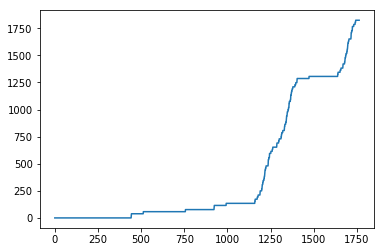

In [59]:
# reprocessed TRU -> LWR UNF
init_salt_tru = np.array(init_salt['init_fuel']) * (sum(init_salt_tru_comp.values()))
metric_dict['TOTAL TRU extracted from LWR UNF'] = init_salt_tru[-1]
plt.plot(init_salt_tru)
print('Total TRU extracted:', init_salt_tru[-1], 'MTHM of TRU')

Total LWR UNF reprocessed: 134927.2543777226 MTHM


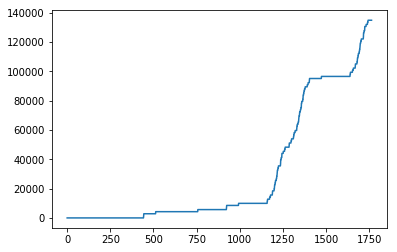

In [60]:
lwr_unf_reprocessed = init_salt_tru / sum(lwr_unf_tru_comp.values())
metric_dict['Total LWR UNF reprocessed'] = lwr_unf_reprocessed[-1]
plt.plot(lwr_unf_reprocessed)
print('Total LWR UNF reprocessed:', lwr_unf_reprocessed[-1], 'MTHM')

In [61]:
# average reprocessing
avg_monthly_rep = lwr_unf_reprocessed[-1] / 1433
metric_dict['Average monthly reprocessing demand of LWR UNF'] = avg_monthly_rep
print('Average monthly reprocessing of LWR UNF:', avg_monthly_rep, 'MTHM/month from 2040')

Average monthly reprocessing of LWR UNF: 94.15719077300949 MTHM/month from 2040


In [62]:
# LWR UNF leftover after reprocessing:
leftover = total_unf - lwr_unf_reprocessed[-1]
metric_dict['LWR UNF leftover inventory'] = leftover
print(leftover, 'MTHM of LWR UNF')

130120.9036222774 MTHM of LWR UNF


In [63]:
# average salt fab
avg_monthly_fab = init_salt['init_fuel'][-1] / 1433
metric_dict['Average monthly fabrication of fuel salt'] = avg_monthly_fab
print('Average monthly fabrication of fuel salt:', avg_monthly_fab, 'MTHM/month from 2040')

Average monthly fabrication of fuel salt: 13.26947842642125 MTHM/month from 2040


In [64]:
ufrac = get_u_massfrac('uox_waste')
print(ufrac)
rep_u = lwr_unf_reprocessed * ufrac
metric_dict['Total reprocessed uranium stockpile'] = rep_u[-1]
print(rep_u[-1])

0.981284662727027
132402.04530472727


In [68]:
# Total Raffinate
agent_ids = an.get_agent_ids(cur, 'Separations')
raff = an.facility_commodity_flux(cur, agent_ids, ['reprocess_waste'], True, True)
total_raff = max(raff['reprocess_waste']) 
metric_dict['Total raffinate stockpile'] = total_raff
print('Total raffinate stockpile: %f' %total_raff)

Total raffinate stockpile: 4024.720749


In [69]:
# Waste from MSR
agent_ids = an.get_prototype_id(cur, 'rebus')
waste = an.facility_commodity_flux(cur, agent_ids, ['waste'], True, False)
waste_cum = an.facility_commodity_flux(cur, agent_ids, ['waste'], True, True)
an.double_axis_bar_line_plot(waste, waste_cum, timestep, 'Years', 'Discharge mass [MTHM]',
                             'Cumulative mass [MTHM]', 'Waste from MSRs', 'msr_waste', init_year)
tot_waste = sum(waste['waste'])
metric_dict['Total waste from MSRs'] = tot_waste
print('Total waste from MSRs: %f' %tot_waste + ' MTHM')

Total waste from MSRs: 2972.488523 MTHM


In [70]:
# Tails accumulation
agent_ids = an.get_agent_ids(cur, 'Enrichment')
tails = an.facility_commodity_flux(cur, agent_ids, ['tailings'], True, False)
tails_accum = sum(tails['tailings'])
metric_dict['Total tails created'] = tails_accum
print('Total tails: %f' %tails_accum)

# or storage
agent_ids = an.get_agent_ids(cur, 'Storage')
fill = an.facility_commodity_flux(cur, agent_ids, ['dep_u'], True, False)
for_fill_commod = sum(fill['dep_u'])
metric_dict['Total tails used'] = for_fill_commod
print('Total tails used = %f' %for_fill_commod)

metric_dict['Total remaining tails inventory'] = tails_accum - for_fill_commod
# total outstanding tails
print('Total outstanding tails inventory = %f' %(tails_accum - for_fill_commod))

Total tails: 1192722.531289
Total tails used = 2969.479669
Total outstanding tails inventory = 1189753.051620


In [71]:
# Natural U used until 2050
source = an.nat_u_timeseries(cur)
metric_dict['Total natural U used'] = max(source) 
print('Total natural U: %f' %max(source))

Total natural U: 1389698.659289


In [72]:
# display all the metrics in LATEX table format:
for key, val in metric_dict.items():
    if val > 1000:
        valstr = '{0:,}'.format(int(val))
    else:
        valstr = '{0:,.2f}'.format(val)
    string = key + ' & ' + valstr + ' \\\\'
    string = string.replace('LWR', '\gls{LWR}')
    string = string.replace('MSR', '\gls{MSR}')
    string = string.replace('UNF', '\gls{UNF}')
    print(string)


US \gls{UNF} UOX generated in 2013-2050 & 78,281 \\
US legacy \gls{LWR} \gls{UNF} in 2013 & 68,072 \\
Total US \gls{LWR} \gls{UNF} inventory in 2050 & 146,353 \\
Total US \gls{LWR} \gls{UNF} inventory generated & 265,048 \\
Total fuel salt mass sent to \gls{MSR}s & 19,015 \\
TOTAL TRU extracted from \gls{LWR} \gls{UNF} & 1,824 \\
Total \gls{LWR} \gls{UNF} reprocessed & 134,927 \\
Average monthly reprocessing demand of \gls{LWR} \gls{UNF} & 94.16 \\
\gls{LWR} \gls{UNF} leftover inventory & 130,120 \\
Average monthly fabrication of fuel salt & 13.27 \\
Total reprocessed uranium stockpile & 132,402 \\
Total raffinate stockpile & 4,024 \\
Total waste from \gls{MSR}s & 2,972 \\
Total tails created & 1,192,722 \\
Total tails used & 2,969 \\
Total remaining tails inventory & 1,189,753 \\
Total natural U used & 1,389,698 \\


In [73]:
# get uox fuel discharge vs time plot
storageids = an.get_agent_ids(cur, 'storage')
fuel_discharge = an.facility_commodity_flux(cur, storageids, ['uox_waste'], False, True)
fuel_discharge_nocum = an.facility_commodity_flux(cur, storageids, ['uox_waste'], False, False)
an.double_axis_bar_line_plot(fuel_discharge_nocum, fuel_discharge, timestep, 'Years', 'Mass [MTHM]',
                             'Mass [MTHM]', 'Discharge LWR UNF accumulation vs time', 'us_lwr_unf', init_year)